# FOR ENV 2


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd
df = pd.read_csv("All_epochs_combined_e2_MN.csv")

In [ ]:
columns_to_keep = ['Reaction time'] + [col for col in df.columns if col.startswith('En_')]
df_filtered = df[columns_to_keep]


In [ ]:
# Configuration
RANDOM_STATE = 42
EPOCHS = 200
BATCH_SIZE = 64
PATIENCE = 15

In [ ]:
# Data Preparation
entropy_cols = [col for col in df.columns if col.startswith("En")]
X = df_filtered[entropy_cols].values
y = df_filtered["Reaction time"].values.astype(np.float32)

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)


In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:

# Convert to Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [ ]:
# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:

# Enhanced Model Architecture
class ReactionTimePredictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.GELU(),

            nn.Linear(64, 32),
            nn.GELU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.main(x)


In [ ]:
# Model Initialization
model = ReactionTimePredictor(X_train_scaled.shape[1])
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
criterion = nn.HuberLoss()  # More robust than MSE


In [ ]:
# Training Setup
train_losses = []
val_losses = []
best_loss = float('inf')
early_stop_counter = 0


In [ ]:
# Training Loop
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensor)
        val_loss = criterion(val_preds, y_test_tensor)

    # Update learning rate
    scheduler.step(val_loss)

    # Store metrics
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss.item())

    # Early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if early_stop_counter >= PATIENCE:
        print("Early stopping triggered!")
        break

Epoch 001 | Train Loss: 0.0766 | Val Loss: 0.0288
Epoch 002 | Train Loss: 0.0289 | Val Loss: 0.0238
Epoch 003 | Train Loss: 0.0277 | Val Loss: 0.0244
Epoch 004 | Train Loss: 0.0268 | Val Loss: 0.0231
Epoch 005 | Train Loss: 0.0259 | Val Loss: 0.0223
Epoch 006 | Train Loss: 0.0250 | Val Loss: 0.0218
Epoch 007 | Train Loss: 0.0248 | Val Loss: 0.0216
Epoch 008 | Train Loss: 0.0244 | Val Loss: 0.0214
Epoch 009 | Train Loss: 0.0237 | Val Loss: 0.0213
Epoch 010 | Train Loss: 0.0235 | Val Loss: 0.0213
Epoch 011 | Train Loss: 0.0231 | Val Loss: 0.0211
Epoch 012 | Train Loss: 0.0227 | Val Loss: 0.0209
Epoch 013 | Train Loss: 0.0221 | Val Loss: 0.0207
Epoch 014 | Train Loss: 0.0224 | Val Loss: 0.0205
Epoch 015 | Train Loss: 0.0222 | Val Loss: 0.0204
Epoch 016 | Train Loss: 0.0218 | Val Loss: 0.0203
Epoch 017 | Train Loss: 0.0218 | Val Loss: 0.0204
Epoch 018 | Train Loss: 0.0217 | Val Loss: 0.0202
Epoch 019 | Train Loss: 0.0212 | Val Loss: 0.0200
Epoch 020 | Train Loss: 0.0212 | Val Loss: 0.0200


In [ ]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [ ]:
# Final Evaluation
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)


In [ ]:
test_preds_np = test_preds.numpy().flatten()
y_test_np = y_test.flatten()


In [ ]:

# Calculate metrics
metrics = {
    "MSE": mean_squared_error(y_test_np, test_preds_np),
    "MAE": mean_absolute_error(y_test_np, test_preds_np),
    "R²": r2_score(y_test_np, test_preds_np)
}

In [ ]:
print("\nFinal Test Metrics:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")



Final Test Metrics:
MSE: 0.0383
MAE: 0.1397
R²: 0.2203


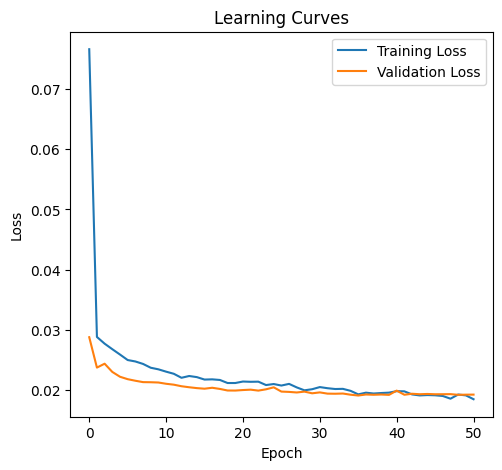

In [ ]:
# Visualization
plt.figure(figsize=(12, 5))

# Learning curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()

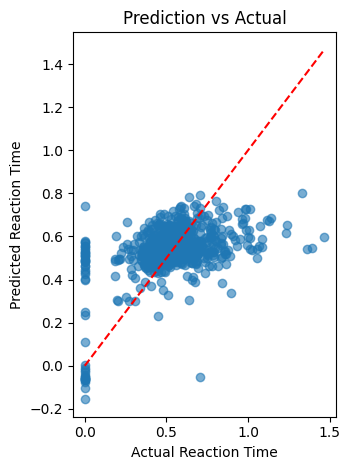

In [ ]:
# Prediction vs Actual
plt.subplot(1, 2, 2)
plt.scatter(y_test_np, test_preds_np, alpha=0.6)
plt.plot([y_test_np.min(), y_test_np.max()],
         [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel('Actual Reaction Time')
plt.ylabel('Predicted Reaction Time')
plt.title('Prediction vs Actual')
plt.tight_layout()
plt.show()

# FOR ENV 1


In [ ]:
import pandas as pd
df = pd.read_csv("All_epochs_combined_e1_MN.csv")

In [ ]:
columns_to_keep = ['Reaction time'] + [col for col in df.columns if col.startswith('En_')]
df_filtered = df[columns_to_keep]


In [ ]:
# Configuration
RANDOM_STATE = 42
EPOCHS = 200
BATCH_SIZE = 64
PATIENCE = 15

In [ ]:
# Data Preparation
entropy_cols = [col for col in df.columns if col.startswith("En")]
X = df_filtered[entropy_cols].values
y = df_filtered["Reaction time"].values.astype(np.float32)

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)


In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:

# Convert to Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [ ]:
# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:

# Enhanced Model Architecture
class ReactionTimePredictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.GELU(),

            nn.Linear(64, 32),
            nn.GELU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.main(x)


In [ ]:
# Model Initialization
model = ReactionTimePredictor(X_train_scaled.shape[1])
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
criterion = nn.HuberLoss()  # More robust than MSE


In [ ]:
# Training Setup
train_losses = []
val_losses = []
best_loss = float('inf')
early_stop_counter = 0


In [ ]:
# Training Loop
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensor)
        val_loss = criterion(val_preds, y_test_tensor)

    # Update learning rate
    scheduler.step(val_loss)

    # Store metrics
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss.item())

    # Early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if early_stop_counter >= PATIENCE:
        print("Early stopping triggered!")
        break

Epoch 001 | Train Loss: 0.0600 | Val Loss: 0.0415
Epoch 002 | Train Loss: 0.0410 | Val Loss: 0.0428
Epoch 003 | Train Loss: 0.0401 | Val Loss: 0.0427
Epoch 004 | Train Loss: 0.0394 | Val Loss: 0.0402
Epoch 005 | Train Loss: 0.0394 | Val Loss: 0.0400
Epoch 006 | Train Loss: 0.0382 | Val Loss: 0.0402
Epoch 007 | Train Loss: 0.0380 | Val Loss: 0.0399
Epoch 008 | Train Loss: 0.0381 | Val Loss: 0.0397
Epoch 009 | Train Loss: 0.0370 | Val Loss: 0.0401
Epoch 010 | Train Loss: 0.0371 | Val Loss: 0.0395
Epoch 011 | Train Loss: 0.0368 | Val Loss: 0.0397
Epoch 012 | Train Loss: 0.0366 | Val Loss: 0.0388
Epoch 013 | Train Loss: 0.0361 | Val Loss: 0.0384
Epoch 014 | Train Loss: 0.0355 | Val Loss: 0.0382
Epoch 015 | Train Loss: 0.0360 | Val Loss: 0.0380
Epoch 016 | Train Loss: 0.0349 | Val Loss: 0.0380
Epoch 017 | Train Loss: 0.0346 | Val Loss: 0.0381
Epoch 018 | Train Loss: 0.0346 | Val Loss: 0.0378
Epoch 019 | Train Loss: 0.0342 | Val Loss: 0.0377
Epoch 020 | Train Loss: 0.0339 | Val Loss: 0.0377


In [ ]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [ ]:
# Final Evaluation
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)


In [ ]:
test_preds_np = test_preds.numpy().flatten()
y_test_np = y_test.flatten()


In [ ]:

# Calculate metrics
metrics = {
    "MSE": mean_squared_error(y_test_np, test_preds_np),
    "MAE": mean_absolute_error(y_test_np, test_preds_np),
    "R²": r2_score(y_test_np, test_preds_np)
}

In [ ]:
print("\nFinal Test Metrics:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")



Final Test Metrics:
MSE: 0.0762
MAE: 0.1820
R²: 0.1198


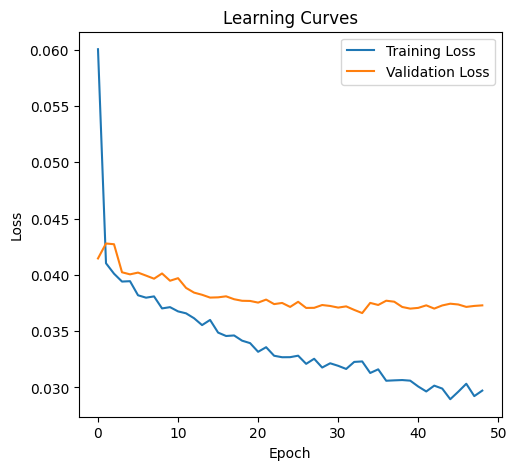

In [ ]:
# Visualization
plt.figure(figsize=(12, 5))

# Learning curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()

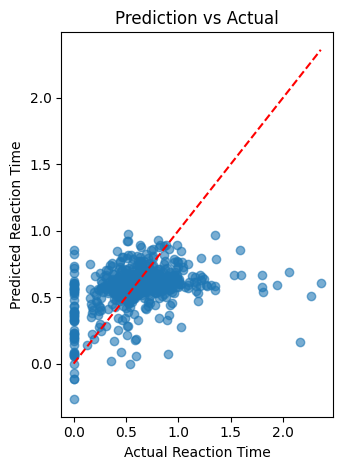

In [ ]:
# Prediction vs Actual
plt.subplot(1, 2, 2)
plt.scatter(y_test_np, test_preds_np, alpha=0.6)
plt.plot([y_test_np.min(), y_test_np.max()],
         [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel('Actual Reaction Time')
plt.ylabel('Predicted Reaction Time')
plt.title('Prediction vs Actual')
plt.tight_layout()
plt.show()

# For ALL ENV

# FOR ENV 1


In [ ]:
import pandas as pd
df = pd.read_csv("All_epochs_combined_MN.csv")

In [ ]:
columns_to_keep = ['Reaction time'] + [col for col in df.columns if col.startswith('En_')]
df_filtered = df[columns_to_keep]


In [ ]:
# Configuration
RANDOM_STATE = 42
EPOCHS = 200
BATCH_SIZE = 64
PATIENCE = 15

In [ ]:
# Data Preparation
entropy_cols = [col for col in df.columns if col.startswith("En")]
X = df_filtered[entropy_cols].values
y = df_filtered["Reaction time"].values.astype(np.float32)

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)


In [ ]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:

# Convert to Tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

In [ ]:
# DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:

# Enhanced Model Architecture
class ReactionTimePredictor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.5),

            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.GELU(),

            nn.Linear(64, 32),
            nn.GELU(),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.main(x)


In [ ]:
# Model Initialization
model = ReactionTimePredictor(X_train_scaled.shape[1])
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
criterion = nn.HuberLoss()  # More robust than MSE


In [ ]:
# Training Setup
train_losses = []
val_losses = []
best_loss = float('inf')
early_stop_counter = 0


In [ ]:
# Training Loop
for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        epoch_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test_tensor)
        val_loss = criterion(val_preds, y_test_tensor)

    # Update learning rate
    scheduler.step(val_loss)

    # Store metrics
    train_loss = epoch_loss / len(train_loader)
    train_losses.append(train_loss)
    val_losses.append(val_loss.item())

    # Early stopping check
    if val_loss < best_loss:
        best_loss = val_loss
        early_stop_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        early_stop_counter += 1

    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if early_stop_counter >= PATIENCE:
        print("Early stopping triggered!")
        break

Epoch 001 | Train Loss: 0.0477 | Val Loss: 0.0363
Epoch 002 | Train Loss: 0.0342 | Val Loss: 0.0350
Epoch 003 | Train Loss: 0.0327 | Val Loss: 0.0346
Epoch 004 | Train Loss: 0.0319 | Val Loss: 0.0342
Epoch 005 | Train Loss: 0.0316 | Val Loss: 0.0337
Epoch 006 | Train Loss: 0.0313 | Val Loss: 0.0333
Epoch 007 | Train Loss: 0.0306 | Val Loss: 0.0332
Epoch 008 | Train Loss: 0.0303 | Val Loss: 0.0326
Epoch 009 | Train Loss: 0.0301 | Val Loss: 0.0327
Epoch 010 | Train Loss: 0.0300 | Val Loss: 0.0323
Epoch 011 | Train Loss: 0.0298 | Val Loss: 0.0321
Epoch 012 | Train Loss: 0.0295 | Val Loss: 0.0320
Epoch 013 | Train Loss: 0.0288 | Val Loss: 0.0315
Epoch 014 | Train Loss: 0.0286 | Val Loss: 0.0313
Epoch 015 | Train Loss: 0.0289 | Val Loss: 0.0313
Epoch 016 | Train Loss: 0.0283 | Val Loss: 0.0308
Epoch 017 | Train Loss: 0.0282 | Val Loss: 0.0310
Epoch 018 | Train Loss: 0.0280 | Val Loss: 0.0309
Epoch 019 | Train Loss: 0.0277 | Val Loss: 0.0313
Epoch 020 | Train Loss: 0.0276 | Val Loss: 0.0308


In [ ]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [ ]:
# Final Evaluation
model.eval()
with torch.no_grad():
    test_preds = model(X_test_tensor)


In [ ]:
test_preds_np = test_preds.numpy().flatten()
y_test_np = y_test.flatten()


In [ ]:

# Calculate metrics
metrics = {
    "MSE": mean_squared_error(y_test_np, test_preds_np),
    "MAE": mean_absolute_error(y_test_np, test_preds_np),
    "R²": r2_score(y_test_np, test_preds_np)
}

In [ ]:
print("\nFinal Test Metrics:")
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")



Final Test Metrics:
MSE: 0.0621
MAE: 0.1621
R²: 0.1754


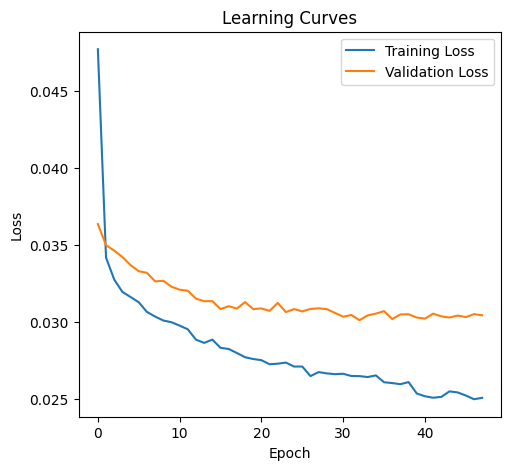

In [ ]:
# Visualization
plt.figure(figsize=(12, 5))

# Learning curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curves')
plt.legend()

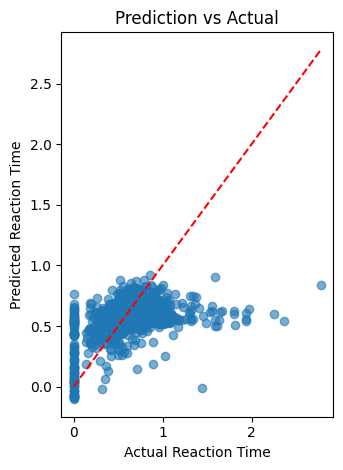

In [ ]:
# Prediction vs Actual
plt.subplot(1, 2, 2)
plt.scatter(y_test_np, test_preds_np, alpha=0.6)
plt.plot([y_test_np.min(), y_test_np.max()],
         [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel('Actual Reaction Time')
plt.ylabel('Predicted Reaction Time')
plt.title('Prediction vs Actual')
plt.tight_layout()
plt.show()